In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

### TF Basics

- Expressions are constructed in terms of **variables** (for parameters) and **placeholders** (for data). 
- Defining expressions means **building their symbolic graph**, but they are **not evaluated**
- Expressions are only evaluated within a session


- **Placeholders** can be matrices (tensors) with different numbers of rows (such as for evaluating an expression with datasets of different length)
- **Variables** have fixed size, they contain the model parameters and can be saved/restored.


- Gradients of expressions can be symbolically obtained with respect to variables and also to placeholders (not usual, as used for data).
- Placeholders cannot have an initial value and must be explicitly fed with data when evaluating them.

See:
- https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/tensorflow.html
- https://github.com/aymericdamien/TensorFlow-Examples
- https://www.kdnuggets.com/2017/05/how-not-program-tensorflow-graph.html
- https://cloud.google.com/blog/big-data/2017/01/learn-tensorflow-and-deep-learning-without-a-phd
- http://cv-tricks.com/tensorflow-tutorial/understanding-alexnet-resnet-squeezenetand-running-on-tensorflow/
- https://github.com/hwalsuklee/tensorflow-mnist-cnn
- https://github.com/vahidk/EffectiveTensorflow
- https://github.com/aymericdamien/TensorFlow-Example

We now define an example function

$$F(t,z) = t z^2 + t^3$$

$F(2,3) = 26$<br/>
$F(2,1) = 10$

In [2]:
tf.reset_default_graph()
t = tf.Variable(initial_value=2, name="t", dtype=tf.float32)
z = tf.Variable(initial_value=3, name="z", dtype=tf.float32)

F = t*tf.pow(z,2) + tf.pow(t,3)
print F
print np.r_[F.graph.get_operations()]

Tensor("add:0", shape=(), dtype=float32)
[<tf.Operation 't/initial_value' type=Const>
 <tf.Operation 't' type=VariableV2> <tf.Operation 't/Assign' type=Assign>
 <tf.Operation 't/read' type=Identity>
 <tf.Operation 'z/initial_value' type=Const>
 <tf.Operation 'z' type=VariableV2> <tf.Operation 'z/Assign' type=Assign>
 <tf.Operation 'z/read' type=Identity> <tf.Operation 'Pow/y' type=Const>
 <tf.Operation 'Pow' type=Pow> <tf.Operation 'mul' type=Mul>
 <tf.Operation 'Pow_1/y' type=Const> <tf.Operation 'Pow_1' type=Pow>
 <tf.Operation 'add' type=Add>]


In [3]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print sess.run(F)
    print sess.run(F, feed_dict = {t:2, z:1})

26.0
10.0


if we do not run an initializer, cannot use initial values and must feed the graph explicitly

In [4]:
with tf.Session() as sess:
    try:
        print sess.run(F)
    except Exception as e:
        print e.message

Attempting to use uninitialized value t
	 [[Node: t/read = Identity[T=DT_FLOAT, _class=["loc:@t"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](t)]]


In [5]:
with tf.Session() as sess:
    print sess.run(F, feed_dict = {z:1, t:2})

10.0


### gradients 
the gradient (set of partial derivatives) of a expression:

$$\nabla{F}(t,z) = \begin{bmatrix}\frac{\partial F}{\partial t}\\
\frac{\partial F}{\partial z}
\end{bmatrix}= \begin{bmatrix}z^2+3t^2\\
2tz
\end{bmatrix}$$

$\nabla F(2,3) = [21, 12]$<br/>
$\nabla F(2,1) = [13, 4]$

TF computes gradients from expressions

In [6]:
grad_F = tf.gradients(F, [t,z])
with tf.Session() as sess:
    print sess.run(grad_F, feed_dict = {t:2, z:3})
    print sess.run(grad_F, feed_dict = {t:2, z:1})

[21.0, 12.0]
[13.0, 4.0]


### using tensors for data and parameters

- $X \in \mathbb{R}^{m\times 2} = \{x_i \in \mathbb{R}^2\}$, data (**placeholder**)
- $y \in \mathbb{R}^m$, data (**placeholder**)
- $\theta \in \mathbb{R}^2$, parameter (**variable**)

$$F(\theta;X,y) = \frac{1}{m}\sum_{i=0}^{m-1} (\theta \cdot x_i - y_i)^2$$


$$\nabla F (\theta; X,y) = \begin{bmatrix}
\frac{\partial F}{\partial \theta_0}\\
\frac{\partial F}{\partial \theta_1}
\end{bmatrix} = \frac{1}{m}2X^{T}\cdot(X\cdot\theta-Y)$$

but with TensorFlow we do not have to compute $\nabla F$!!!!


In [7]:
tf.reset_default_graph()
t = tf.Variable(initial_value=np.r_[[[0,0]]].T, name="t", dtype=tf.float32)
X = tf.placeholder(name="X", dtype=tf.float32, shape = (None, 2))
y = tf.placeholder(name="y", dtype=tf.float32, shape = (None, 1))

F = tf.reduce_mean(tf.pow(tf.matmul(X,t)-y,2))

In [8]:
train_X = np.random.randint(10, size=(5,2)).astype(np.float32)
train_y = np.random.randint(10, size=(len(train_X),1)).astype(np.float32)
print train_X
print train_y

[[ 4.  2.]
 [ 4.  9.]
 [ 9.  1.]
 [ 8.  6.]
 [ 5.  0.]]
[[ 2.]
 [ 8.]
 [ 9.]
 [ 5.]
 [ 5.]]


function value with TensorFlow

In [9]:
params_t = np.random.randint(10,size=(2,1)).astype(np.float32)
print "params t\n", params_t
with tf.Session() as sess:
    print "\nF(t;X,y)=",sess.run(F, feed_dict = {t:params_t, X: train_X, y: train_y})

params t
[[ 7.]
 [ 6.]]

F(t;X,y)= 3797.8


function value numeric

In [10]:
print np.mean((train_X.dot(params_t)-train_y)**2)

3797.8


$\nabla F (\theta; X,y)$ with TensorFlow

In [11]:
grad_F = tf.gradients(F, t)
with tf.Session() as sess:
    print sess.run(grad_F, feed_dict = {t:params_t, X: train_X, y: train_y})[0]


[[ 733.59997559]
 [ 529.59997559]]


$\nabla F (\theta; X,y)$ directly from gradient expression

In [12]:
2*train_X.T.dot(train_X.dot(params_t)-train_y)/len(train_X)

array([[ 733.59997559],
       [ 529.59997559]], dtype=float32)

### implementing gradient descent

recall the gradient descent iterative algorithm shown in last notebook. Observe that computing the cost within the gradient descent loop **is not necessary** it is only done for plotting purposes. 

Execution time is also measured. Run the experiment commenting the lines required for logging and compare times.

In [13]:
d = pd.read_csv("data/houses.csv")
data_X = np.hstack((np.ones((len(d),1)), d[["area"]].as_matrix())).astype(np.float32)
data_y = d.value.as_matrix().reshape(-1,1).astype(np.float32)
data_X = data_X/data_X.max(axis=0)
data_y = data_y/np.max(data_y)

In [14]:
init_params =  np.r_[np.random.random(), (np.random.random())].reshape(-1,1).astype(np.float32)

learning_rate = .1

def hm_gd(init_params, data_X, data_y, keep_logs=True):
    def n_cost(t):
        return np.mean((data_X.dot(t)-data_y)**2)

    def n_grad(t):
        return 2*data_X.T.dot(data_X.dot(t)-data_y)/len(data_X)
    hm_params        = init_params.copy()
    hm_cost, hm_grad = n_cost(hm_params), n_grad(hm_params)

    hm_log_cost, hm_log_params = [hm_cost], [hm_params]

    for i in range(50):
        hm_grad    = n_grad(hm_params)
        hm_params -= learning_rate*hm_grad
        # the following lines are for logging
        if keep_logs:
            hm_cost    = n_cost(hm_params)
            hm_log_cost.append(hm_cost)        
            hm_log_params.append(hm_params.copy())
    return np.r_[hm_log_params].reshape(-1,len(hm_params)), np.r_[hm_log_cost]

hm_log_params, hm_log_cost = hm_gd(init_params, data_X, data_y)
print hm_log_params[-1]
%timeit hm_gd(init_params, data_X, data_y)


[ 0.33194801  0.4815028 ]
1000 loops, best of 3: 1.72 ms per loop


In [15]:
big_X = np.vstack([data_X]*20000)
big_y = np.vstack([data_y]*20000)
print big_X.shape, big_y.shape
%timeit hm_gd(init_params, big_X, big_y, keep_logs=False)

(2000000, 2) (2000000, 1)
1 loop, best of 3: 484 ms per loop


In [16]:
def plot_logs(log_params, log_cost, name, figsize=None, **lstyle):
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.subplot(121)
    if figsize is not None:
        plt.grid()
    plt.plot(log_cost, color="black", label=name, **lstyle)
    plt.xlabel("iteration")
    plt.title("loss")
    plt.legend()
    plt.subplot(122)
    plt.plot(log_params[:,0], label=r"$\theta_0$ "+name, color="blue", **lstyle)
    plt.plot(log_params[:,1], label=r"$\theta_1$ "+name, color="red", **lstyle)
    plt.legend(loc="center left", bbox_to_anchor=(1,.5))
    plt.title("model parameters")
    plt.xlabel("iteration")
    if figsize is not None:
        plt.grid()


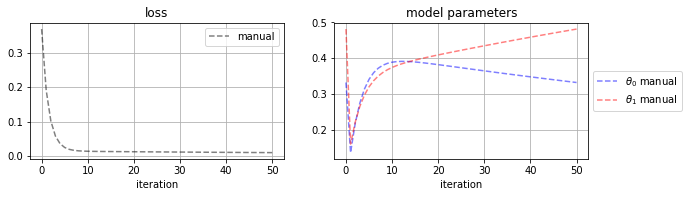

In [17]:
plot_logs(hm_log_params, hm_log_cost, figsize=(10,2.5), name="manual", ls="--", alpha=.5)

### using TF

we do the same with TensorFlow expressions. Observe that creating the expressions `F` and `grad_F` takes a fixed amount of time.

In [18]:
from time import time
def tf_gd(init_params, data_X, data_y, keep_logs=True, time_detail=False):
    t1 = time()
    tf.reset_default_graph()
    t = tf.Variable(initial_value=np.r_[[[0,0]]].T, name="t", dtype=tf.float32)
    X = tf.placeholder(name="X", dtype=tf.float32, shape = (None, 2))
    y = tf.placeholder(name="y", dtype=tf.float32, shape = (None, 1))

    F = tf.reduce_mean(tf.pow(tf.matmul(X,t)-y,2))
    grad_F = tf.gradients(F, t)
    t2 = time()
    with tf.Session() as sess:
        tf_params = init_params.copy()
        tf_cost, tf_grad = sess.run(F, feed_dict = {t:tf_params, X: data_X, y: data_y}),\
                           sess.run(grad_F, feed_dict = {t:tf_params, X: data_X, y: data_y})[0]
        tf_log_cost, tf_log_params = [tf_cost], [tf_params]
        for i in range(50):
            tf_grad    = sess.run(grad_F, feed_dict = {t:tf_params, X: data_X, y: data_y})[0]
            tf_params -= learning_rate*tf_grad
            # the following lines are for logging
            if keep_logs:
                tf_cost    = sess.run(F, feed_dict = {t:tf_params, X: data_X, y: data_y})        
                tf_log_cost.append(tf_cost)
                tf_log_params.append(tf_params.copy())
    t3 = time()
    if time_detail:
        print "building expressions %.2f ms"%((t2-t1)*1000)
        print "optimizing           %.2f ms"%((t3-t2)*1000)
    return np.r_[tf_log_params].reshape(-1,len(tf_params)), np.r_[tf_log_cost]

tf_log_params, tf_log_cost = tf_gd(init_params, data_X, data_y, time_detail=True)
print tf_log_params[-1]
%timeit tf_gd(init_params, data_X, data_y)

building expressions 51.47 ms
optimizing           46.56 ms
[ 0.33194801  0.4815028 ]
10 loops, best of 3: 77.9 ms per loop


observe that evaluating for logging is expensive

In [19]:
tf_log_params, tf_log_cost = tf_gd(init_params, data_X, data_y, time_detail=True, keep_logs=False)
%timeit tf_gd(init_params, data_X, data_y, keep_logs=False)

building expressions 83.98 ms
optimizing           31.00 ms
10 loops, best of 3: 63 ms per loop


In [20]:
big_X = np.vstack([data_X]*20000)
big_y = np.vstack([data_y]*20000)
%timeit tf_gd(init_params, big_X, big_y, keep_logs=False)

1 loop, best of 3: 7.97 s per loop


/opt/miniconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


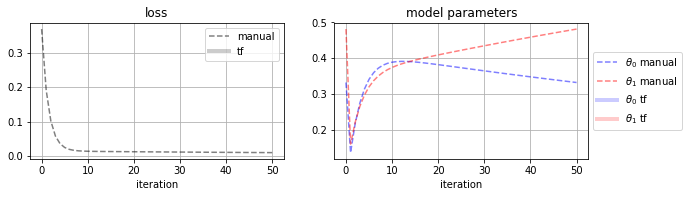

In [21]:
plot_logs(hm_log_params, hm_log_cost, figsize=(10,2.5), name="manual", ls="--", alpha=.5)
plot_logs(tf_log_params, tf_log_cost, name="tf", lw=4, alpha=.2)

### using a TF optimizer

and now we use the **exact same** gradient descent, but implemented in TF.  Observe that:

- we do not manipulate expicitly the gradient (the optimizer does), but we still have to implement the loop.
- there is no need to feed the parameters as the optimizer updates them.

In [22]:
def tf_optimizer(init_params, data_X, data_y, keep_logs=True):
    tf.reset_default_graph()
    t = tf.Variable(initial_value=init_params, name="t", dtype=tf.float32)
    X = tf.placeholder(name="X", dtype=tf.float32, shape = (None, 2))
    y = tf.placeholder(name="y", dtype=tf.float32, shape = (None, 1))

    F = tf.reduce_mean(tf.pow(tf.matmul(X,t)-y,2))

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(F)
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        tf_cost, tf_params    = sess.run([F,t], feed_dict = {X: data_X, y: data_y})        
        tf_log_cost, tf_log_params = [tf_cost], [tf_params]
        for i in range(50):
            k = sess.run(optimizer, feed_dict={X: data_X, y: data_y})
            # the following lines are just for logging
            if keep_logs:
                tf_cost, tf_params    = sess.run([F, t], feed_dict = {X: data_X, y: data_y})  
                tf_log_cost.append(tf_cost)
                tf_log_params.append(tf_params)
    return np.r_[tf_log_params].reshape(-1,len(tf_params)), np.r_[tf_log_cost]
    
otf_log_params, otf_log_cost = tf_optimizer(init_params, data_X, data_y)
print otf_log_params[-1]
%timeit tf_optimizer(init_params, data_X, data_y)

[ 0.33194801  0.4815028 ]
10 loops, best of 3: 88.4 ms per loop


In [23]:
big_X = np.vstack([data_X]*20000)
big_y = np.vstack([data_y]*20000)
%timeit tf_optimizer(init_params, big_X, big_y, keep_logs=False)

1 loop, best of 3: 9.19 s per loop


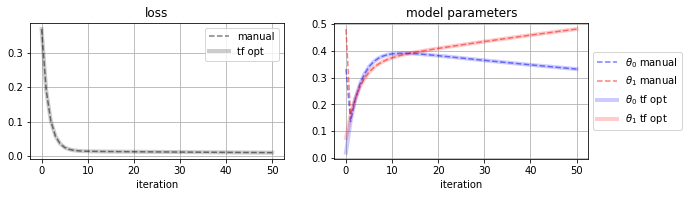

In [24]:
plot_logs(hm_log_params, hm_log_cost, figsize=(10,2.5), name="manual", ls="--", alpha=.5)
plot_logs(otf_log_params, otf_log_cost, name="tf opt", lw=4, alpha=.2)

### using constants

We can set the data as constants in our expression (similar to the `sympy` example in a previous notebook) and TF will get a bit faster. Now no data is fed into the expression graph in each iteration, all is included within the expresion. This is ok for this example, but not when using batches.

[ 0.33194801  0.4815028 ]
10 loops, best of 3: 82.3 ms per loop


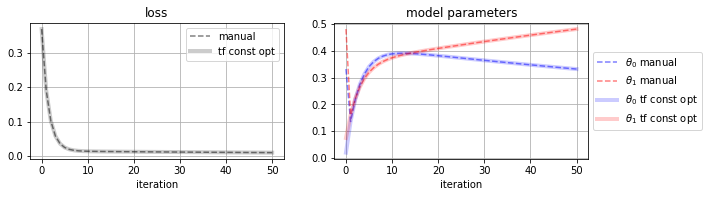

In [25]:
def tf_const_optimizer(init_params, data_X, data_y, keep_logs=True):
    tf.reset_default_graph()
    t = tf.Variable(initial_value=init_params.copy(), name="t", dtype=tf.float32)
    const_X = tf.constant(data_X)
    const_y = tf.constant(data_y)
    F = tf.reduce_mean(tf.pow(tf.matmul(const_X,t)-const_y,2))

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(F)
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        tf_cost, tf_params    = sess.run([F,t])        
        tf_log_cost, tf_log_params = [tf_cost], [tf_params]
        for i in range(50):
            k = sess.run(optimizer)
            # the following lines are just for logging     
            if keep_logs:
                tf_cost, tf_params = sess.run([F,t])        
                tf_log_cost.append(tf_cost)
                tf_log_params.append(tf_params)
    
    return np.r_[tf_log_params].reshape(-1,len(tf_params)), np.r_[tf_log_cost]
    
ctf_log_params, ctf_log_cost = tf_const_optimizer(init_params, data_X, data_y)
print ctf_log_params[-1]
%timeit tf_const_optimizer(init_params, data_X, data_y)
plot_logs(hm_log_params, hm_log_cost, figsize=(10,2.5), name="manual", ls="--", alpha=.5)
plot_logs(ctf_log_params, ctf_log_cost, name="tf const opt", lw=4, alpha=.2)

In [26]:
big_X = np.vstack([data_X]*20000)
big_y = np.vstack([data_y]*20000)
%timeit tf_const_optimizer(init_params, big_X, big_y, keep_logs=False)

1 loop, best of 3: 5.18 s per loop


### feeding batches

observe that with smaller batches (more gradient updates) we get faster descent. **How could we avoid `feed_dict`?**

In [28]:
from rlx.ml import Batches

def tf_batch_optimizer(init_params, data_X, data_y, batch_size=5):
    tf.reset_default_graph()

    X = tf.placeholder(name="X", dtype=tf.float32, shape = (None, 2))
    y = tf.placeholder(name="y", dtype=tf.float32, shape = (None, 1))
    t = tf.Variable(initial_value=init_params, name="t", dtype=tf.float32)
    F = tf.reduce_mean(tf.pow(tf.matmul(X,t)-y,2))
    optimizer = tf.train.GradientDescentOptimizer(.1).minimize(F)

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        tf_cost, tf_params = sess.run([F,t], feed_dict = {X: data_X, y: data_y})        
        tf_log_cost, tf_log_params = [tf_cost], [tf_params]
        
        for step in range(50):
            for i in range(len(data_X)/batch_size+(1 if len(data_X)%batch_size!=0 else 0) ):
                batch_start = i*batch_size
                batch_end   = np.min(((batch_start + batch_size) , len(data_X)))
                k = sess.run(optimizer, feed_dict={X: data_X[batch_start:batch_end], 
                                                   y: data_y[batch_start:batch_end]})
        
            tf_cost, tf_params = sess.run([F,t], feed_dict = {X: data_X, y: data_y})        
            tf_log_cost.append(tf_cost)
            tf_log_params.append(tf_params)
    
    return np.r_[tf_log_params].reshape(-1,len(tf_params)), np.r_[tf_log_cost]
    
btf_log_params, btf_log_cost = tf_batch_optimizer(init_params, data_X, data_y)
print btf_log_params[-1]

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
[ 0.05234953  0.90069395]


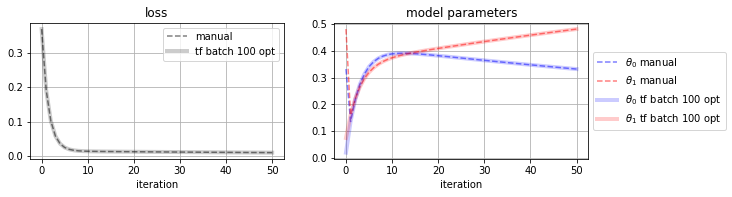

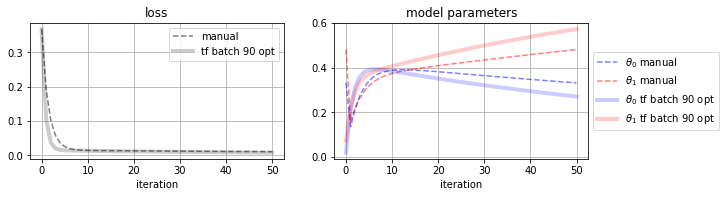

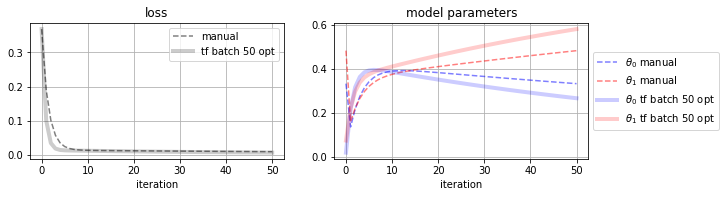

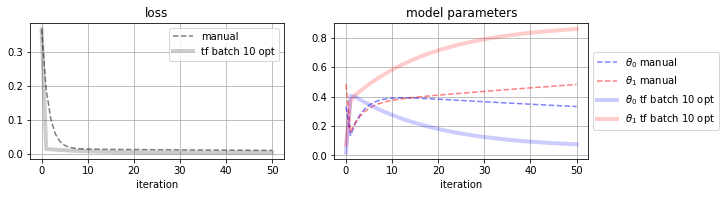

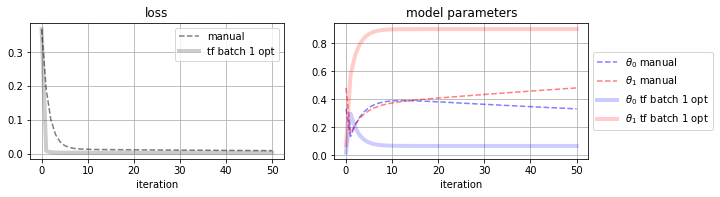

In [29]:
for batch_size in np.r_[[1] + range(10,len(data_X),40) + [len(data_X)]][::-1]:
    btf_log_params, btf_log_cost = tf_batch_optimizer(init_params, data_X, data_y, batch_size = batch_size)
    plot_logs(hm_log_params, hm_log_cost, figsize=(10,2.5), name="manual", ls="--", alpha=.5)
    plot_logs(btf_log_params, btf_log_cost, name="tf batch %d opt"%batch_size, lw=4, alpha=.2)

### monitoring progress with TensorBoard 

run

    tensorboard --logdir log
    
from the notebooks folder


In [30]:
def tf_mon_optimizer(init_params, data_X, data_y, batch_size=5, n_steps=50):
    from tensorflow.python.client import timeline

    tf.reset_default_graph()

    with tf.name_scope("data"):
        X = tf.placeholder(name="X", dtype=tf.float32, shape = (None, 2))
        y = tf.placeholder(name="y", dtype=tf.float32, shape = (None, 1))

    with tf.name_scope("params"):
        t = tf.Variable(initial_value=init_params, name="t", dtype=tf.float32)
        tf.summary.histogram("params", t)
        tf.summary.scalar("params_0", t[0,0])
        tf.summary.scalar("params_1", t[1,0])

    with tf.name_scope("loss"):
        F = tf.reduce_mean(tf.pow(tf.matmul(X,t)-y,2))
        tf.summary.scalar('loss', F)

    with tf.name_scope("optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(.1).minimize(F)

    summary_merged = tf.summary.merge_all()

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        !rm -rf log
        summary_writer = tf.summary.FileWriter("log/linreg",sess.graph)
        sess.run(init)
        
        n_batches = len(data_X)/batch_size+(1 if len(data_X)%batch_size!=0 else 0) 
        print "using", n_batches, "batches"
        
        for step in range(n_steps):
            for i in range(n_batches):
                batch_start = i*batch_size
                batch_end   = np.min(((batch_start + batch_size) , len(data_X)))
                
                sess.run(optimizer, feed_dict={X: data_X[batch_start:batch_end], 
                                               y: data_y[batch_start:batch_end]})
                    
                summary_item = sess.run(summary_merged, feed_dict = {X: data_X, y: data_y})  
                summary_writer.add_summary(summary_item, step)

        tf_params = sess.run(t)
                
    return tf_params

tf_params = tf_mon_optimizer(init_params, data_X, data_y, batch_size=len(data_X), n_steps=50)
print tf_params

using 1 batches
[[ 0.33194801]
 [ 0.4815028 ]]


### profiling execution

open `chrome://tracing` in Google Chrome and load files under `traces`

In [31]:
from tensorflow.python.client import timeline


def tf_prof_optimizer(init_params, data_X, data_y, trace_name="", batch_size=5, n_steps=50):

    tf.reset_default_graph()

    with tf.name_scope("data"):
        X = tf.placeholder(name="X", dtype=tf.float32, shape = (None, 2))
        y = tf.placeholder(name="y", dtype=tf.float32, shape = (None, 1))

    with tf.name_scope("params"):
        t = tf.Variable(initial_value=init_params, name="t", dtype=tf.float32)

    with tf.name_scope("loss"):
        F = tf.reduce_mean(tf.pow(tf.matmul(X,t)-y,2))

    with tf.name_scope("optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(.1).minimize(F)

    init = tf.global_variables_initializer()
    
    run_metadata = tf.RunMetadata()
    run_options  = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)

    with tf.Session() as sess:
        sess.run(init)
        
        n_batches = len(data_X)/batch_size+(1 if len(data_X)%batch_size!=0 else 0) 
        print "using", n_batches, "batches"
        for step in range(n_steps):
            for i in range(n_batches):
                batch_start = i*batch_size
                batch_end   = np.min(((batch_start + batch_size) , len(data_X)))
                sess.run(optimizer, feed_dict={X: data_X[batch_start:batch_end], 
                                               y: data_y[batch_start:batch_end]},
                                    options=run_options, run_metadata=run_metadata)  
            trace = timeline.Timeline(step_stats=run_metadata.step_stats)

            with open('traces/timeline_%s_%03d.ctf.json'%(trace_name,step), 'w') as trace_file:
                trace_file.write(trace.generate_chrome_trace_format())                                                           
                    

        tf_params = sess.run(t, feed_dict = {X: data_X, y: data_y})        
                
    return tf_params

!rm -rf traces
!mkdir traces

for n in [1,10,1000,10000,100000]:
    big_X = np.vstack([data_X]*n)
    big_y = np.vstack([data_y]*n)
    tf_params = tf_prof_optimizer(init_params, big_X, big_y, batch_size=len(big_X), n_steps=10, trace_name=str(n))
    print tf_params


using 1 batches
[[ 0.38878459]
 [ 0.37411988]]
using 1 batches
[[ 0.38878459]
 [ 0.37411988]]
using 1 batches
[[ 0.38878414]
 [ 0.37412083]]
using 1 batches
[[ 0.38877931]
 [ 0.37412539]]
using 1 batches
[[ 0.38877064]
 [ 0.3741537 ]]
